In [1]:
import warnings
warnings.filterwarnings('ignore')

### Librerias

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from dtaidistance import dtw
from sklearn.impute import SimpleImputer
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px
import plotly.graph_objects as go

import os
from datetime import datetime

### Configuración

In [3]:
def crear_directorios_xp(EXPERIMENTO, DIRECTORIO="../EXPERIMENTOS/"):
    MODELOS = os.path.join(DIRECTORIO, EXPERIMENTO, 'Saved Models')
    PLOTS = os.path.join(DIRECTORIO, EXPERIMENTO, 'Plots')
    PREDS = os.path.join(DIRECTORIO, EXPERIMENTO, 'Predictions')

    # Crear los directorios si no existen
    for directory in [MODELOS, PLOTS, PREDS]:
        os.makedirs(directory, exist_ok=True)

    return MODELOS, PLOTS, PREDS

In [4]:
EXPERIMENTO = "dtw_02"
MODELOS, PLOTS, PREDS = crear_directorios_xp(EXPERIMENTO)

### Carga de datos

In [20]:
os.getcwd()

'/home/fernando_damian_coz/labo3-2024v/DTW'

In [44]:
#productos = "~buckets/fdc/datasets/tb_productos_descripcion.txt"
#stocks = "~buckets/fdc/datasets/b_stocks.txt.gz"
sells = "/home/fernando_damian_coz/buckets/b1/datasets/sell-in.txt.gz"
#prod_filtro = "~buckets/fdc/datasets/productos_a_predecir.txt"

#df_productos = pd.read_csv(productos, delimiter='\t')
#df_stocks = pd.read_csv(stocks, compression='gzip', delimiter='\t')
df_sells = pd.read_csv(sells, compression='gzip', delimiter='\t')
#prods_filtro = pd.read_csv(prod_filtro)

### Filtrado

Primero filtro los productos que únicamente me solicitan para realizar la predicción

In [6]:
df_sells_filtrado = df_sells[df_sells['product_id'].isin(prods_filtro['product_id'].to_list())]
df_prods_filtrado = df_productos[df_productos['product_id'].isin(prods_filtro['product_id'].to_list())]
df_stocks_filtrado = df_stocks[df_stocks['product_id'].isin(prods_filtro['product_id'].to_list())]

### Agrupo por <producto, cliente>

In [45]:
df_sells_agg = df_sells.groupby(['product_id', 'customer_id', 'periodo','plan_precios_cuidados']).agg({'tn': 'sum','cust_request_qty': 'sum','cust_request_tn': 'sum'}).reset_index()
df_sells_agg

,product_id,customer_id,periodo,plan_precios_cuidados,tn,cust_request_qty,cust_request_tn
0,20001,10001,201701,0,99.43861,11,99.43861
1,20001,10001,201702,0,198.84365,23,198.84365
2,20001,10001,201703,0,92.46537,33,92.46537
3,20001,10001,201704,0,13.29728,8,13.29728
4,20001,10001,201705,0,101.00563,15,101.20711
...,...,...,...,...,...,...,...
2945813,21295,10011,201701,0,0.00699,1,0.00699
2945814,21296,10003,201708,0,0.00651,1,0.00651
2945815,21297,10542,201701,0,0.00579,1,0.00579
2945816,21298,10003,201708,0,0.00573,1,0.00573


### Master dataframe

In [46]:
unique_product_ids = df_sells_agg['product_id'].unique()
unique_customer_ids = df_sells_agg['customer_id'].unique()
unique_periodos = df_sells_agg['periodo'].unique()

all_combinations = pd.MultiIndex.from_product(
    [unique_product_ids, unique_customer_ids, unique_periodos], 
    names=['product_id', 'customer_id', 'periodo']
)

# Convert the multi-index to a DataFrame
all_combinations_df = pd.DataFrame(index=all_combinations).reset_index()

# Merge with the original DataFrame to fill in the missing values with 0
complete_df = pd.merge(all_combinations_df, df_sells_agg, on=['product_id', 'customer_id', 'periodo'], how='left').fillna(0)

### Join Productos

In [34]:
df_sells_agg  = df_sells_agg.merge(df_prods_filtrado, on='product_id', how='left')
df_sells_agg

,product_id,customer_id,periodo,plan_precios_cuidados,tn,cust_request_qty,cust_request_tn,cat1,cat2,cat3,brand,sku_size,descripcion
0,20001,10001,201701,0,99.43861,11,99.43861,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma
1,20001,10001,201702,0,198.84365,23,198.84365,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma
2,20001,10001,201703,0,92.46537,33,92.46537,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma
3,20001,10001,201704,0,13.29728,8,13.29728,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma
4,20001,10001,201705,0,101.00563,15,101.20711,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293476,21276,10462,201905,0,0.00148,1,0.00148,PC,PIEL1,Cara,NIVEA,140,reconstruccion
2293477,21276,10462,201910,0,0.00075,1,0.00075,PC,PIEL1,Cara,NIVEA,140,reconstruccion
2293478,21276,10495,201903,0,0.00148,1,0.00148,PC,PIEL1,Cara,NIVEA,140,reconstruccion
2293479,21276,10550,201909,0,0.00075,1,0.00075,PC,PIEL1,Cara,NIVEA,140,reconstruccion


### Normalizo

In [12]:
""" Normalización agrupado por product_id
mean_std_dict = {}

data_transformed = []

for product_id in df_sells_agg['product_id'].unique():
    product_data = df_sells_agg[df_sells_agg['product_id'] == product_id]
    time_series = product_data['tn'].values.reshape(-1, 1)
    scaler = StandardScaler()
    scaled_time_series = scaler.fit_transform(time_series)
    mean_std_dict[product_id] = (scaler.mean_[0], scaler.scale_[0])
    transformed_df = product_data.copy()
    transformed_df['tn'] = scaled_time_series
    data_transformed.append(transformed_df)

df_transformed = pd.concat(data_transformed)
"""

" Normalización agrupado por product_id\nmean_std_dict = {}\n\ndata_transformed = []\n\nfor product_id in df_sells_agg['product_id'].unique():\n    product_data = df_sells_agg[df_sells_agg['product_id'] == product_id]\n    time_series = product_data['tn'].values.reshape(-1, 1)\n    scaler = StandardScaler()\n    scaled_time_series = scaler.fit_transform(time_series)\n    mean_std_dict[product_id] = (scaler.mean_[0], scaler.scale_[0])\n    transformed_df = product_data.copy()\n    transformed_df['tn'] = scaled_time_series\n    data_transformed.append(transformed_df)\n\ndf_transformed = pd.concat(data_transformed)\n"

In [47]:
mean_std_dict = {}

data_transformed = []

grouped = df_sells_agg.groupby(['product_id', 'customer_id'])

for (product_id, customer_id), group in grouped:
    time_series = group['tn'].values.reshape(-1, 1)
    scaler = StandardScaler()
    scaled_time_series = scaler.fit_transform(time_series)
    mean_std_dict[(product_id, customer_id)] = (scaler.mean_[0], scaler.scale_[0])
    
    transformed_df = group.copy()
    transformed_df['tn'] = scaled_time_series
    data_transformed.append(transformed_df)

df_transformed = pd.concat(data_transformed).reset_index(drop=True)

In [48]:
df_sells_agg = df_transformed
df_sells_agg

,product_id,customer_id,periodo,plan_precios_cuidados,tn,cust_request_qty,cust_request_tn
0,20001,10001,201701,0,-0.735475,11,99.43861
1,20001,10001,201702,0,0.215317,23,198.84365
2,20001,10001,201703,0,-0.802173,33,92.46537
3,20001,10001,201704,0,-1.559402,8,13.29728
4,20001,10001,201705,0,-0.720487,15,101.20711
...,...,...,...,...,...,...,...
2945813,21295,10011,201701,0,0.000000,1,0.00699
2945814,21296,10003,201708,0,0.000000,1,0.00651
2945815,21297,10542,201701,0,0.000000,1,0.00579
2945816,21298,10003,201708,0,0.000000,1,0.00573


### Dynamic Time Warping

In [49]:
# Create a new column combining product_id and customer_id
df_sells_agg['product_customer_id'] = df_sells_agg['product_id'].astype(str) + df_sells_agg['customer_id'].astype(str)
df_sells_agg['periodo'] = pd.to_datetime(df_sells_agg['periodo'].astype(str), format='%Y%m')

# Pivot the dataframe
pivot_df = df_sells_agg.pivot(index='periodo', columns='product_customer_id', values='tn')

In [50]:
pivot_df.head()

product_customer_id,2000110001,2000110002,2000110003,2000110004,2000110005,2000110006,2000110007,2000110008,2000110009,2000110010,...,2129010077,2129110003,2129210003,2129310003,2129410003,2129510011,2129610003,2129710542,2129810003,2129910003
periodo,,,,,,,,,,,,,,,,,,,,,
2017-01-01,-0.735475,-0.127745,0.369179,-0.268741,0.011000,0.052442,-0.875544,-0.238058,-0.451861,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
2017-02-01,0.215317,-1.019440,-1.480046,-0.984877,-0.974489,-0.036061,-1.587160,-0.847371,-0.006139,-0.241233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-01,-0.802173,-0.306084,0.284710,0.713824,-0.974489,-0.520497,-0.703418,-0.513505,-0.513039,0.114153,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-01,-1.559402,-0.525817,-0.752303,0.289745,-1.279729,-1.167966,0.066527,-0.557790,-1.142294,0.347845,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-01,-0.720487,-0.266415,0.243317,-0.236356,1.347712,1.722563,2.098584,-0.271036,0.824128,-0.711849,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
imputer = SimpleImputer(strategy='mean')
pivot_df_imputed = pd.DataFrame(imputer.fit_transform(pivot_df), columns=pivot_df.columns, index=pivot_df.index)

In [58]:
distance_matrix = dtw.distance_matrix_fast(pivot_df_imputed.T.value)

AttributeError: 'DataFrame' object has no attribute 'value'

### Clustering algomerativo

In [34]:
max_clusters = 100
silhouette_scores = []

for n_clusters in range(2, max_clusters + 1):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='complete')
    labels = clustering.fit_predict(distance_matrix)
    silhouette_avg = silhouette_score(distance_matrix, labels, metric='precomputed')
    silhouette_scores.append(silhouette_avg)


optimal_n_clusters = np.argmax(silhouette_scores) + 2  # Minimo 2 clusters

print(f"Nuúmero de clusters óptimos según score Silhouette: {optimal_n_clusters}")
print("Score Silhouette para cada conjunto de clusters:")
for i, score in enumerate(silhouette_scores):
    print(f"Numbero de clusters = {i+2}: {score}")

Nuúmero de clusters óptimos según score Silhouette: 2
Score Silhouette para cada conjunto de clusters:
Numbero de clusters = 2: 0.18360953210074166
Numbero de clusters = 3: 0.1760415542707568
Numbero de clusters = 4: 0.1647312919305378
Numbero de clusters = 5: 0.14477120993614007
Numbero de clusters = 6: 0.14440264150086204
Numbero de clusters = 7: 0.14685893263658265
Numbero de clusters = 8: 0.15005557556177349
Numbero de clusters = 9: 0.14924578933189048
Numbero de clusters = 10: 0.15050615722089317
Numbero de clusters = 11: 0.14975503137689328
Numbero de clusters = 12: 0.15249810187056945
Numbero de clusters = 13: 0.15157103665349228
Numbero de clusters = 14: 0.15219339785233849
Numbero de clusters = 15: 0.1446652037008941
Numbero de clusters = 16: 0.14593122445292198
Numbero de clusters = 17: 0.14853113478678245
Numbero de clusters = 18: 0.14932727927843537
Numbero de clusters = 19: 0.1500466286650933
Numbero de clusters = 20: 0.15072220855384846
Numbero de clusters = 21: 0.1357297

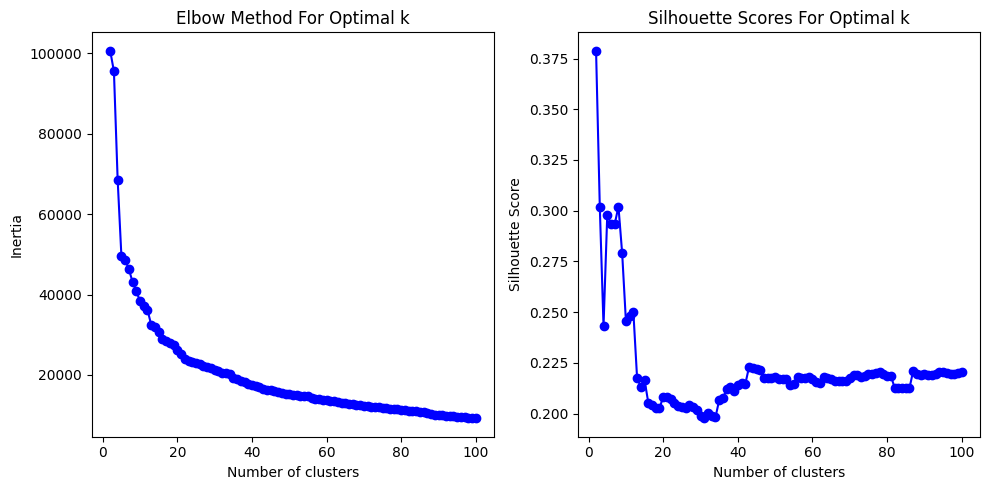

In [35]:
silhouette_scores = []
inertia_values = []

euclidean_matrix = np.array(distance_matrix)

for n_clusters in range(2, max_clusters + 1):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='complete')
    labels = clustering.fit_predict(euclidean_matrix)
    
    # Compute silhouette score
    silhouette_avg = silhouette_score(euclidean_matrix, labels, metric='euclidean')
    silhouette_scores.append(silhouette_avg)
    
    # Compute inertia (sum of squared distances to the cluster mean)
    inertia = 0
    for cluster_id in np.unique(labels):
        cluster_points = euclidean_matrix[labels == cluster_id]
        cluster_mean = np.mean(cluster_points, axis=0)
        inertia += np.sum(np.square(cluster_points - cluster_mean))
    inertia_values.append(inertia)

# Plot the elbow method
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters + 1), inertia_values, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')

plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores For Optimal k')

plt.tight_layout()
plt.show()

In [19]:
from scipy.signal import find_peaks

optimal_clusters_silhouette = np.argmax(silhouette_scores) + 2  # +2 because range starts from 2

# Determine the optimal number of clusters based on elbow method (inertia values)
# Calculate the second derivative to find the elbow point
second_derivative = np.diff(inertia_values, n=2)
elbow_point = np.argmin(second_derivative) + 2  # +2 because range starts from 2

# Alternatively, using peaks in the second derivative
peaks, _ = find_peaks(-second_derivative)  # Negative because we are looking for minima
if len(peaks) > 0:
    elbow_point = peaks[0] + 2  # +2 because range starts from 2
else:
    elbow_point = np.argmin(second_derivative) + 2

print(f'Optimal number of clusters (Silhouette): {optimal_clusters_silhouette}')
print(f'Optimal number of clusters (Elbow): {elbow_point}')

Optimal number of clusters (Silhouette): 2
Optimal number of clusters (Elbow): 5


### K-means

In [36]:
silhouette_scores = []

for n_clusters in range(2, max_clusters + 1):
    clustering = KMeans(n_clusters=n_clusters, random_state=42)
    labels = clustering.fit_predict(distance_matrix)
    
    silhouette_avg = silhouette_score(distance_matrix, labels, metric='euclidean')
    silhouette_scores.append(silhouette_avg)

optimal_n_clusters = np.argmax(silhouette_scores) + 2  # Minimo 2 clusters

print(f"Nuúmero de clusters óptimos según score Silhouette: {optimal_n_clusters}")
print("Score Silhouette para cada conjunto de clusters:")
for i, score in enumerate(silhouette_scores):
    print(f"Numbero de clusters = {i+2}: {score}")

Nuúmero de clusters óptimos según score Silhouette: 2
Score Silhouette para cada conjunto de clusters:
Numbero de clusters = 2: 0.3812384783432243
Numbero de clusters = 3: 0.3206677443271074
Numbero de clusters = 4: 0.35012226710453714
Numbero de clusters = 5: 0.3041830029495909
Numbero de clusters = 6: 0.3013689780548214
Numbero de clusters = 7: 0.25180267736050727
Numbero de clusters = 8: 0.25281095260245867
Numbero de clusters = 9: 0.24572433371056185
Numbero de clusters = 10: 0.25068712913075014
Numbero de clusters = 11: 0.23748030025598088
Numbero de clusters = 12: 0.24363760541266455
Numbero de clusters = 13: 0.23599779378176253
Numbero de clusters = 14: 0.2406927019208653
Numbero de clusters = 15: 0.2366646409414455
Numbero de clusters = 16: 0.2322892073671948
Numbero de clusters = 17: 0.2226654192260253
Numbero de clusters = 18: 0.23176856760769238
Numbero de clusters = 19: 0.23738696884029534
Numbero de clusters = 20: 0.23613428415937357
Numbero de clusters = 21: 0.24341767694

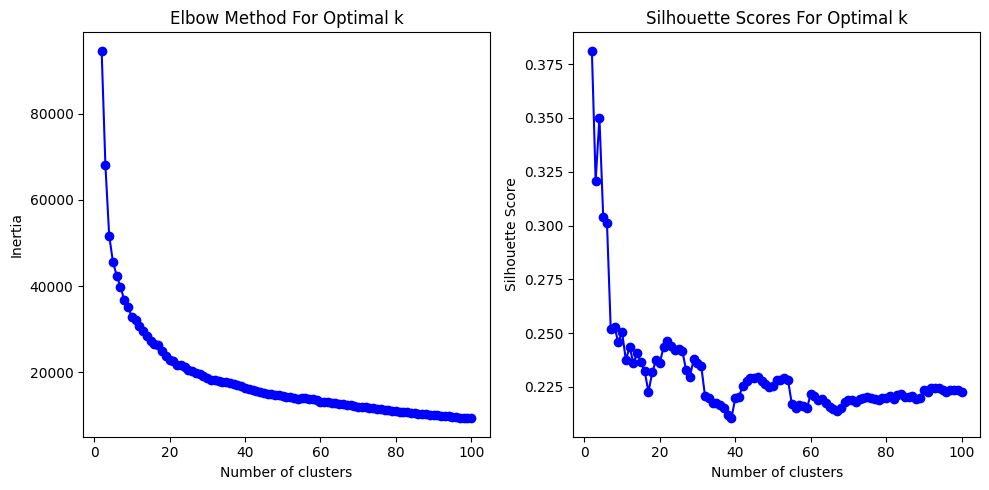

In [37]:
silhouette_scores = []
inertia_values = []

for n_clusters in range(2, max_clusters + 1):
    clustering = KMeans(n_clusters=n_clusters, random_state=42)
    labels = clustering.fit_predict(distance_matrix)
    
    # Compute silhouette score
    silhouette_avg = silhouette_score(distance_matrix, labels, metric='euclidean')
    silhouette_scores.append(silhouette_avg)
    
    # Compute inertia (sum of squared distances to closest cluster center)
    inertia_values.append(clustering.inertia_)

# Plot the elbow method
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters + 1), inertia_values, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')

plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores For Optimal k')

plt.tight_layout()
plt.show()

In [22]:
optimal_clusters_silhouette = np.argmax(silhouette_scores) + 2  # +2 because range starts from 2

# Determine the optimal number of clusters based on elbow method (inertia values)
# Calculate the second derivative to find the elbow point
second_derivative = np.diff(inertia_values, n=2)
elbow_point = np.argmin(second_derivative) + 2  # +2 because range starts from 2

# Alternatively, using peaks in the second derivative
peaks, _ = find_peaks(-second_derivative)  # Negative because we are looking for minima
if len(peaks) > 0:
    elbow_point = peaks[0] + 2  # +2 because range starts from 2
else:
    elbow_point = np.argmin(second_derivative) + 2

print(f'Optimal number of clusters (Silhouette): {optimal_clusters_silhouette}')
print(f'Optimal number of clusters (Elbow): {elbow_point}')

Optimal number of clusters (Silhouette): 2
Optimal number of clusters (Elbow): 5


In [38]:
nc = 100

In [39]:
distance_matrix = dtw.distance_matrix_fast(pivot_df_imputed.T.values)

clustering = AgglomerativeClustering(n_clusters=nc, metric='precomputed', linkage='complete')
labels = clustering.fit_predict(distance_matrix)

cluster_map = {product: label for product, label in zip(pivot_df_imputed.columns, labels)}

In [42]:
cluster_df = pd.DataFrame(list(cluster_map.items()), columns=['product_customer_id', 'cluster'])
data_with_cluster = df_sells_agg.merge(cluster_df, on='product_customer_id', how='left')

data_with_cluster_plot = data_with_cluster
data_with_cluster_plot['product_customer_id'] = data_with_cluster_plot['product_customer_id'].astype(str)

In [43]:
data_with_cluster

,product_id,customer_id,periodo,plan_precios_cuidados,tn,cust_request_qty,cust_request_tn,product_customer_id,cluster
0,20001,10001,2017-01-01,0,-0.735475,11,99.43861,2000110001,79
1,20001,10001,2017-02-01,0,0.215317,23,198.84365,2000110001,79
2,20001,10001,2017-03-01,0,-0.802173,33,92.46537,2000110001,79
3,20001,10001,2017-04-01,0,-1.559402,8,13.29728,2000110001,79
4,20001,10001,2017-05-01,0,-0.720487,15,101.20711,2000110001,79
...,...,...,...,...,...,...,...,...,...
6167,20001,10584,2019-06-01,0,-1.000000,1,0.02240,2000110584,18
6168,20001,10584,2019-12-01,0,1.000000,1,0.04481,2000110584,18
6169,20001,10587,2019-09-01,0,0.000000,1,0.04481,2000110587,18
6170,20001,10589,2017-01-01,0,0.000000,1,0.11193,2000110589,18


### Plots

In [26]:
nc = 100

output_dir = PLOTS + f"/preds{nc}/"
os.makedirs(output_dir, exist_ok=True)

In [27]:
distance_matrix = dtw.distance_matrix_fast(pivot_df_imputed.T.values)

clustering = AgglomerativeClustering(n_clusters=nc, metric='precomputed', linkage='complete')
labels = clustering.fit_predict(distance_matrix)

cluster_map = {product: label for product, label in zip(pivot_df_imputed.columns, labels)}

In [28]:
cluster_df = pd.DataFrame(list(cluster_map.items()), columns=['product_id', 'cluster'])
data_with_cluster = df_sells_agg.merge(cluster_df, on='product_id', how='left')

data_with_cluster_plot = data_with_cluster
data_with_cluster_plot['product_id'] = data_with_cluster_plot['product_id'].astype(str)

fig = px.scatter(cluster_df, x='product_id', y='cluster', color='cluster', hover_data=['product_id'],
                 title='Productos por cluster')
fig.write_image(os.path.join(output_dir, f'Productos por cluster{nc}_de_{nc}.png'), width=800, height=600)
fig.show()

Función para ploteo de clusters

In [24]:
def plot_cluster_series(df, cluster_number, output_dir):
    cluster_data = df[df['cluster'] == cluster_number]
    fig = go.Figure()
        
    for product_id in cluster_data['product_id'].unique():
        product_data = cluster_data[cluster_data['product_id'] == product_id]
        fig.add_trace(go.Scatter(x=product_data['periodo'], y=product_data['tn'], mode='lines', name=product_id))
    
    fig.update_layout(title=f'Series de tiempo - Cluster {cluster_number} de {nc}',
                      xaxis_title='Periodo',
                      yaxis_title='Tn',
                      legend_title='Product ID')
    
    fig.write_image(os.path.join(output_dir, f'Cluster_{cluster_number}_de_{nc}.png'), width=800, height=600)
    #fig.show()

In [25]:
for clust_n in range(0,nc,1):
    plot_cluster_series(data_with_cluster_plot, clust_n, output_dir)

NameError: name 'nc' is not defined

In [35]:
data_with_cluster.query("cluster == 46")[['product_id', 'cat1', 'cat2', 'cat3', 'brand', 'descripcion']].drop_duplicates()

,product_id,cat1,cat2,cat3,brand,descripcion
180,20006,HC,VAJILLA,Cristalino,LIMPIEX,Desengrasante cristal Limon
396,20012,HC,ROPA ACONDICIONADOR,ACONDICIONADOR,DOWNY,Sabor 15
576,20017,HC,VAJILLA,Opaco,LIMPIEX,Desengrasante crema colageno
2488,20077,FOODS,SOPAS Y CALDOS,Salsas Wet,MAGGI,Pomarola Tradicional
2524,20079,FOODS,SOPAS Y CALDOS,Pure de Papas,MAGGI,Pure Listo
2719,20086,FOODS,OTROS,Almidon,HARINAMA,Almidon
3024,20096,FOODS,OTROS,Almidon,HARINAMA,Almidon
6299,20228,FOODS,SOPAS Y CALDOS,Pure de Papas,MAGGI,Pure Listo
7011,20255,PC,DEOS,Aero,DEOS1,Antibacterial
9009,20325,FOODS,ADEREZOS,Barbacoa,NATURA,Salsa Barbacoa


Guardo los resultados

In [95]:
cluster_df.to_csv(PREDS + f'/{nc}_clusters.csv', index=False)

In [139]:
data_with_cluster.query("product_id == '20004'")[['product_id', 'cat1', 'cat2', 'cat3', 'brand', 'descripcion', 'cluster']].drop_duplicates()


,product_id,cat1,cat2,cat3,brand,descripcion,cluster
108,20004,FOODS,ADEREZOS,Mayonesa,NATURA,Regular sin TACC,45
